The following codes were ran on Kaggle in an attempt to find the best hyperparameters for the model with TfidfVectorizer and LinearSVC classifier based after the notebook on [model tuning](../02_model_tuning.ipynb).

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline # to compactly pack multiple modeling operations
from sklearn.svm import LinearSVC # to build our classification model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score, classification_report # to access results from binary classification task
 
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text module in sklearn.
from sklearn.feature_extraction.text import TfidfVectorizer 

In [2]:
# Load dataset
sq_forums = pd.read_csv('/kaggle/input/sq-forums/sq_forums.csv')
print(sq_forums.shape)
sq_forums.head(3)

(27375, 4)


,title,link,reply,forum
0,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,https://milelion.com/2020/09/30/conf...amenit...,amenity_catering_lounges
1,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,Originally posted by jammed View Post https:/...,amenity_catering_lounges
2,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,I’ll report back in 3 week’s time if they are...,amenity_catering_lounges


In [3]:
# Convert y response variable in 'forum' column to 0 for amenity_catering_lounges and 1 for krisflyer
sq_forums['forum'] = sq_forums['forum'].map({'amenity_catering_lounges': 0, 'krisflyer': 1})
sq_forums.head(3)

,title,link,reply,forum
0,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,https://milelion.com/2020/09/30/conf...amenit...,0
1,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,Originally posted by jammed View Post https:/...,0
2,2020 Biz Class Amenity Kit,http://www.sqtalk.com/forum/forum/singapore-ai...,I’ll report back in 3 week’s time if they are...,0


In [4]:
# Set data up for modelling
X = sq_forums['reply']
y = sq_forums['forum']

In [5]:
# Split the data into the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [6]:
# Set up a pipeline with tf-idf vectorizer with default parameters and LinearSVC classifier
# class_weight = 'balanced' to handle our data imbalance

pipe_linearsvc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')), 
    ('lsvc', LinearSVC(class_weight='balanced')) 
])

In [7]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 1, 2, 3
# Maximum number of documents needed to include token: 70%, 80%, 90%
# Generate 10 random C values

pipe_tvec_lsvc_params = {
    'tvec__max_features': [7_000, 8_000, 9_000, 10_000],
    'tvec__min_df': [2, 3, 4, 5], # min 1, 2 or 3 documents needed to include token
    'tvec__max_df': [.3, .4, .5, .6, .7], # max number of documents needed to include token
    'lsvc__C': np.linspace(0.0001, 2, 10), # generate 10 random C values to GridSearch over
}

In [8]:
# Instantiate GridSearchCV using stratified kfold cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs3_tvec_lsvc = GridSearchCV(pipe_linearsvc, # the object that we are optimizing
                  param_grid=pipe_tvec_lsvc_params, # parameters values to be searched
                  cv=cv) # using stratified kfold cv

In [9]:
%%time
# Fit GridSearch to training data
gs3_tvec_lsvc.fit(X_train, y_train)

CPU times: user 1h 15min 14s, sys: 8.83 s, total: 1h 15min 23s
Wall time: 1h 15min 25s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('lsvc',
                                        LinearSVC(class_weight='balanced'))]),
             param_grid={'lsvc__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                         'tvec__max_df': [0.3, 0.4, 0.5, 0.6, 0.7],
                         'tvec__max_features': [7000, 8000, 9000, 10000],
                         'tvec__min_df': [2, 3, 4, 5]})

In [10]:
# See what hyperparameter combination yielded the best result
gs3_tvec_lsvc.best_params_ 

{'lsvc__C': 0.2223111111111111,
 'tvec__max_df': 0.4,
 'tvec__max_features': 10000,
 'tvec__min_df': 2}

In [11]:
# Find the mean cross-validated score of the best_estimator
print(gs3_tvec_lsvc.best_score_)

0.9130095208885642


In [12]:
# Score model on training set.
gs3_tvec_lsvc.score(X_train, y_train)

0.9559203156202816

In [13]:
# Score model on testing set.
gs3_tvec_lsvc.score(X_test, y_test)

0.9205143191116306

In [14]:
# Get predictions
preds = gs3_tvec_lsvc.predict(X_test)
print(preds)

[0 1 1 ... 1 1 0]


In [15]:
# confusion matrix yields a 2-D array
confusion_matrix(y_test, preds) 

array([[2481,  222],
       [ 322, 3819]])

In [16]:
# ravel() to convert to 1-D and Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(tn, fp, fn, tp)

2481 222 322 3819


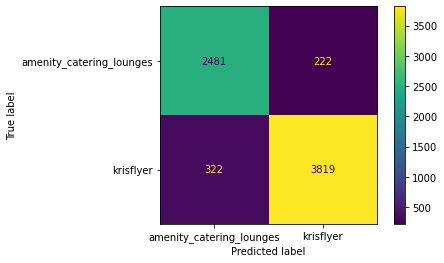

In [17]:
# plot confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['amenity_catering_lounges', 'krisflyer'])
disp.plot();

In [18]:
# Find 'accuracy' score from sklearn metrics (same as test_score above)
accuracy = accuracy_score(y_test, preds)
f'accuracy score = {accuracy}'

'accuracy score = 0.9205143191116306'

In [19]:
# Find 'sensitivity' score from sklearn metrics
sensitivity = recall_score(y_test, preds)
f'sensitivity score = {sensitivity}'

'sensitivity score = 0.9222410045882637'

In [20]:
# Find 'precision' score from sklearn metrics
precision = precision_score(y_test, preds)
f'precision score = {precision}'

'precision score = 0.9450631031922792'

In [21]:
# Find 'f1 score' from sklearn metrics
f1_score = f1_score(y_test, preds)
f'f1 score = {f1_score}'

'f1 score = 0.933512588609142'

In [22]:
# Summarizing Precision, Sensitivity and F1-score
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2703
           1       0.95      0.92      0.93      4141

    accuracy                           0.92      6844
   macro avg       0.92      0.92      0.92      6844
weighted avg       0.92      0.92      0.92      6844



In [23]:
# Find 'specificity score' 
specificity = tn / (tn + fp)
f'specificity score = {specificity}'

'specificity score = 0.9178690344062154'

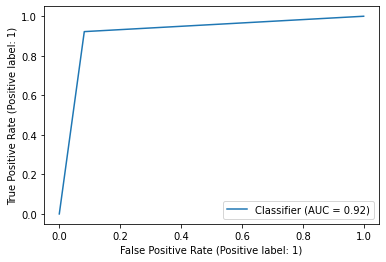

In [24]:
# Plot roc curve from sklearn metrics
RocCurveDisplay.from_predictions(y_test, preds)
plt.show()

In [25]:
# Find 'roc auc score' from sklearn metrics
roc_auc_score = roc_auc_score(y_test, preds)
f'roc auc score = {roc_auc_score}'

'roc auc score = 0.9200550194972394'

In summary, the scores using the different metrics are as below:
|**Metrics**|**CountVectorizer with MultinomialNB() (Baseline)**|**TfidfVectorizer with LinearSVC (with default parameters)**|**TfidfVectorizer with LinearSVC (with GridSearch)**|**TfidfVectorizer with LinearSVC (with GridSearch2)**|**TfidfVectorizer with LinearSVC (with GridSearch3)**|
|:---|:---|:---|:---|:---|:---|
|cross_val_score|0.840|0.916|0.906|0.910|0.913|
|train_score|0.858|0.981|0.943|0.949|0.956|
|test_score|0.844|0.923|0.916|0.919|0.921|
|sensitivity|0.986|0.926|0.917|0.919|0.922|
|precision|0.801|0.946|0.942|0.945|0.945|
|f1 score|0.884|0.936|0.929|0.932|0.934|
|specificity|0.626|0.918|0.913|0.918|0.918|
|roc auc|0.806|0.922|0.915|0.919|0.920|